# Precipitation analysis


## FTP Connection

### Connection Parameters

In [207]:
server = "opendata.dwd.de"
user   = "anonymous"
passwd = ""

### FTP Directory Definition and Station Description Filename Pattern

In [208]:
# The topic of interest.
# topic_dir = "/hourly/precipitation/recent/"
topic_dir = "/daily/more_precip/historical/"

# This is the search pattern common to ALL station description file names 
station_desc_pattern = "_Beschreibung_Stationen.txt"

# Below this directory tree node all climate data are stored.
ftp_climate_data_dir = "/climate_environment/CDC/observations_germany/climate/"
ftp_dir =  ftp_climate_data_dir + topic_dir

### Local Directories

In [209]:
local_ftp_dir         = "data/original/DWD/"      # Local directory to store local ftp data copies, the local data source or input data. 
local_ftp_station_dir = local_ftp_dir + topic_dir # Local directory where local station info is located
local_ftp_ts_dir      = local_ftp_dir + topic_dir # Local directory where time series downloaded from ftp are located

local_generated_dir   = "data/generated/DWD/" # The generated of derived data in contrast to local_ftp_dir
local_station_dir     = local_generated_dir + topic_dir # Derived station data, i.e. the CSV file
local_ts_merged_dir   = local_generated_dir + topic_dir # Parallel merged time series, wide data frame with one TS per column
local_ts_appended_dir = local_generated_dir + topic_dir # Serially appended time series, long data frame for QGIS TimeManager Plugin

In [210]:
print(local_ftp_dir)
print(local_ftp_station_dir)
print(local_ftp_ts_dir)
print()
print(local_generated_dir)
print(local_station_dir)
print(local_ts_merged_dir)
print(local_ts_appended_dir)

data/original/DWD/
data/original/DWD//daily/more_precip/historical/
data/original/DWD//daily/more_precip/historical/

data/generated/DWD/
data/generated/DWD//daily/more_precip/historical/
data/generated/DWD//daily/more_precip/historical/
data/generated/DWD//daily/more_precip/historical/


In [211]:
import os
os.makedirs(local_ftp_dir,exist_ok = True) # it does not complain if the dir already exists.
os.makedirs(local_ftp_station_dir,exist_ok = True)
os.makedirs(local_ftp_ts_dir,exist_ok = True)

os.makedirs(local_generated_dir,exist_ok = True)
os.makedirs(local_station_dir,exist_ok = True)
os.makedirs(local_ts_merged_dir,exist_ok = True)
os.makedirs(local_ts_appended_dir,exist_ok = True)

### FTP Connect

In [212]:
import ftplib
ftp = ftplib.FTP(server)
res = ftp.login(user=user, passwd = passwd)
print(res)

230 Login successful.


In [213]:
ret = ftp.cwd(".")

In [214]:
#ftp.quit()

### FTP Grab File Function

In [215]:
def grabFile(ftpfullname,localfullname):
    try:
        ret = ftp.cwd(".") # A dummy action to chack the connection and to provoke an exception if necessary.
        localfile = open(localfullname, 'wb')
        ftp.retrbinary('RETR ' + ftpfullname, localfile.write, 1024)
        localfile.close()
    
    except ftplib.error_perm:
        print("FTP ERROR. Operation not permitted. File not found?")

    except ftplib.error_temp:
        print("FTP ERROR. Timeout.")

    except ConnectionAbortedError:
        print("FTP ERROR. Connection aborted.")



### Generate Pandas Dataframe from FTP Directory Listing

In [216]:
import pandas as pd
import os

def gen_df_from_ftp_dir_listing(ftp, ftpdir):
    lines = []
    flist = []
    try:    
        res = ftp.retrlines("LIST "+ftpdir, lines.append)
    except:
        print("Error: ftp.retrlines() failed. ftp timeout? Reconnect!")
        return
        
    if len(lines) == 0:
        print("Error: ftp dir is empty")
        return
    
    for line in lines:
#        print(line)
        [ftype, fsize, fname] = [line[0:1], int(line[31:42]), line[56:]]
#        itemlist = [line[0:1], int(line[31:42]), line[56:]]
#        flist.append(itemlist)
        
        fext = os.path.splitext(fname)[-1]
        
        if fext == ".zip":
            station_id = int(fname.split("_")[2])
        else:
            station_id = -1 
        
        flist.append([station_id, fname, fext, fsize, ftype])
        
        

    df_ftpdir = pd.DataFrame(flist,columns=["station_id", "name", "ext", "size", "type"])
    return(df_ftpdir)

In [217]:
df_ftpdir = gen_df_from_ftp_dir_listing(ftp, ftp_dir)

In [218]:
df_ftpdir.head()

station_id                                               name   ext  \
0          -1  BESCHREIBUNG_obsgermany_climate_daily_more_pre...  .pdf   
1          -1  DESCRIPTION_obsgermany_climate_daily_more_prec...  .pdf   
2          -1           RR_Tageswerte_Beschreibung_Stationen.txt  .txt   
3           1     tageswerte_RR_00001_19120101_19860630_hist.zip  .zip   
4           2     tageswerte_RR_00002_19510101_20061231_hist.zip  .zip   

      size type  
0    72261    -  
1    71026    -  
2  1202717    -  
3   113546    -  
4    85314    -

### Dataframe with TS Zip Files

In [219]:
#df_ftpdir["ext"]==".zip"
df_zips = df_ftpdir[df_ftpdir["ext"]==".zip"]
df_zips.set_index("station_id", inplace = True)
df_zips.head()

name   ext    size type
station_id                                                                   
1           tageswerte_RR_00001_19120101_19860630_hist.zip  .zip  113546    -
2           tageswerte_RR_00002_19510101_20061231_hist.zip  .zip   85314    -
3           tageswerte_RR_00003_18910101_20110331_hist.zip  .zip  172281    -
4           tageswerte_RR_00004_19510101_19791031_hist.zip  .zip   47379    -
6           tageswerte_RR_00006_19821101_20191231_hist.zip  .zip   51899    -

### Download the Station Description File

In [220]:
station_fname = df_ftpdir[df_ftpdir['name'].str.contains(station_desc_pattern)]["name"].values[0]
print(station_fname)

# ALternative
#station_fname2 = df_ftpdir[df_ftpdir["name"].str.match("^.*Beschreibung_Stationen.*txt$")]["name"].values[0]
#print(station_fname2)

RR_Tageswerte_Beschreibung_Stationen.txt


In [221]:
print("grabFile: ")
print("From: " + ftp_dir + station_fname)
print("To:   " + local_ftp_station_dir + station_fname)
grabFile(ftp_dir + station_fname, local_ftp_station_dir + station_fname)

grabFile: 
From: /climate_environment/CDC/observations_germany/climate//daily/more_precip/historical/RR_Tageswerte_Beschreibung_Stationen.txt
To:   data/original/DWD//daily/more_precip/historical/RR_Tageswerte_Beschreibung_Stationen.txt


In [222]:
# extract column names. They are in German (de)
# We have to use codecs because of difficulties with character encoding (German Umlaute)
import codecs

def station_desc_txt_to_csv(txtfile, csvfile):
    file = codecs.open(txtfile,"r","utf-8")
    r = file.readline()
    file.close()
    colnames_de = r.split()
    colnames_de
    
    translate = \
    {'Stations_id':'station_id',
     'von_datum':'date_from',
     'bis_datum':'date_to',
     'Stationshoehe':'altitude',
     'geoBreite': 'latitude',
     'geoLaenge': 'longitude',
     'Stationsname':'name',
     'Bundesland':'state'}
    
    colnames_en = [translate[h] for h in colnames_de]
    
    # Skip the first two rows and set the column names.
    df = pd.read_fwf(txtfile,skiprows=2,names=colnames_en, parse_dates=["date_from","date_to"],index_col = 0)
    
    # write csv
    df.to_csv(csvfile, sep = ";")
    return(df)

In [223]:
basename = os.path.splitext(station_fname)[0]
df_stations = station_desc_txt_to_csv(local_ftp_station_dir + station_fname, local_station_dir + basename + ".csv")
df_stations.head()

date_from    date_to  altitude  latitude  longitude  \
station_id                                                        
1          1912-01-01 1986-06-30       478   47.8413     8.8493   
2          1951-01-01 2006-12-31       138   50.8066     6.0996   
3          1891-01-01 2011-03-31       202   50.7827     6.0941   
4          1951-01-01 1979-10-31       243   50.7683     6.1207   
6          1982-11-01 2020-08-30       455   48.8361    10.0598   

                           name                state  
station_id                                            
1                          Aach    Baden-Württemberg  
2           Aachen (Kläranlage)  Nordrhein-Westfalen  
3                        Aachen  Nordrhein-Westfalen  
4                  Aachen-Brand  Nordrhein-Westfalen  
6            Aalen-Unterrombach    Baden-Württemberg

### Select Stations Located in NRW from Station Description Dataframe

In [224]:
station_ids_selected = df_stations[df_stations['state'].str.contains("Bayern")].index
station_ids_selected

Int64Index([   10,    15,    16,    17,    24,    27,    29,    37,    46,
               48,
            ...
            15930, 15943, 15945, 15953, 15965, 15977, 19087, 19120, 19127,
            19128],
           dtype='int64', name='station_id', length=1298)

In [225]:
# Create variable with TRUE if state is Bayern
isNRW = df_stations['state'] == "Bayern"

# Create variable with TRUE if date_to is latest date (indicates operation up to now)
isOperational = df_stations['date_to'] == df_stations.date_to.max() 

isBefore1950 = df_stations['date_from'] < '2010'

# select on both conditions
dfNRW = df_stations[isNRW & isOperational & isBefore1950]
print("Number of stations in NRW: \n", dfNRW.count())
dfNRW

Number of stations in NRW: 
 date_from    520
date_to      520
altitude     520
latitude     520
longitude    520
name         520
state        520
dtype: int64


date_from    date_to  altitude  latitude  longitude  \
station_id                                                        
29         1951-01-01 2020-08-30       260   49.7175    10.9101   
46         1941-01-01 2020-08-30       325   48.9450    12.4639   
55         1951-01-01 2020-08-30       509   47.8779    12.0240   
57         1978-01-01 2020-08-30       461   48.4799    11.0521   
63         1951-01-01 2020-08-30       747   47.8172    10.5374   
...               ...        ...       ...       ...        ...   
13786      2008-03-01 2020-08-30       436   48.5505    11.1210   
14137      2009-07-01 2020-08-30       294   50.2346    10.8626   
14300      2009-09-01 2020-08-30       671   47.7477    11.2554   
14670      1941-01-01 2020-08-30       383   48.8777    11.8903   
15977      1999-08-01 2020-08-30       434   49.1442    10.6623   

                                   name   state  
station_id                                       
29               Adelsdorf (Kläranlage)  Bayern  
46                             Aholfing  Bayern  
55                Aibling, Bad-Ellmosen  Bayern  
57          Hollenbach/Bayern-Schönbach  Bayern  
63                              Aitrang  Bayern  
...                                 ...     ...  
13786        Pöttmes-Schnellmannskreuth  Bayern  
14137              Weitramsdorf-Tambach  Bayern  
14300            Obersöchering-Reinthal  Bayern  
14670                  Kelheim-Thaldorf  Bayern  
15977                 Arberg-Gothendorf  Bayern  

[520 rows x 7 columns]

In [226]:
list_lon=[]
list_lat=[]
for index,row in dfNRW.iterrows():
    list_lon.append(row['longitude'])
    list_lat.append(row['latitude'])

In [227]:
#distance calculation using Neunburg Vom Wald longitude and latitude value from google
from geopy import distance
from geopy import Point

# mystation = point("6.94 51.5496")
# print (lon)

list_dist_station=[]

for f, b in zip(list_lon, list_lat):
    myP= str(f)+" "+str(b)
    mystation = Point(myP)
    xanten = Point("12.38621 49.34782")

    result = distance.distance(mystation,xanten).kilometers
    list_dist_station.append(result)
# print(list_dist_station)
l1 = sorted(list_dist_station)[:6]
l1
res = [list_dist_station.index(i) for i in l1]
stations_dist_min_df=dfNRW.iloc[res]

In [228]:
# list of three nearest station in xanten 
stations_dist_min_df


date_from    date_to  altitude  latitude  longitude  \
station_id                                                        
6281       2003-04-26 2020-08-30       420   49.3608    12.4477   
4224       1951-01-01 2020-08-30       388   49.2412    12.4125   
3739       1948-10-01 2020-08-30       596   49.4521    12.4365   
118        1951-01-01 2020-08-30       388   49.4053    12.2852   
572        1951-01-01 2020-08-30       420   49.2986    12.2400   
5015       1951-01-01 2020-08-30       670   49.5238    12.4175   

                                     name   state  
station_id                                         
6281        Neunburg vorm Wald-Eixendorf(  Bayern  
4224                        Roding-Neubäu  Bayern  
3739                        Oberviechtach  Bayern  
118                             Altendorf  Bayern  
572                Bodenwöhr-Altenschwand  Bayern  
5015                      Teunz-Wildstein  Bayern

In [229]:
# Create variable with TRUE if state is Nordrhein-Westfalen
isNRW = df_stations['state'] == "Bayern"

# Create variable with TRUE if date_to is latest date (indicates operation up to now)
isOperational = df_stations['date_to'] == df_stations.date_to.max() 

# df_stations.get_value()
xanten= df_stations['name'] == "Roding-Neubäu"
dfNRW = df_stations[xanten]
dfNRW.head()

date_from    date_to  altitude  latitude  longitude  \
station_id                                                        
4224       1951-01-01 2020-08-30       388   49.2412    12.4125   

                     name   state  
station_id                         
4224        Roding-Neubäu  Bayern

In [230]:
lat=dfNRW['latitude']
lat_all=df_stations['latitude']

isLatCovered = (df_stations['latitude'] < dfNRW.iloc[0]['latitude'] + 0.5)&(df_stations['latitude'] > dfNRW.iloc[0]['latitude'] - 0.5)
isLongCovered = (df_stations['longitude'] < dfNRW.iloc[0]['longitude'] + 0.5)&(df_stations['longitude'] > dfNRW.iloc[0]['longitude'] - 0.5)

dateFilter=(df_stations['date_from']<='2015')&(df_stations['date_to']>='2018')
# df_stations['latitude'] > dfNRW.iloc[0]['latitude']
    #latValue=df_stations['latitude']
# isBefore1950 = df_stations['date_from'] < '1950'

# select on both conditions
dfNRW = df_stations[isNRW & isLatCovered&isLongCovered&dateFilter] 
#print("Number of stations in NRW: \n", dfNRW.count())

dfNRW.head()

date_from    date_to  altitude  latitude  longitude  \
station_id                                                        
46         1941-01-01 2020-08-30       325   48.9450    12.4639   
103        1978-01-01 2020-08-30       364   48.8960    12.2170   
118        1951-01-01 2020-08-30       388   49.4053    12.2852   
128        1951-01-01 2020-08-30       446   49.0844    12.3232   
572        1951-01-01 2020-08-30       420   49.2986    12.2400   

                              name   state  
station_id                                  
46                        Aholfing  Bayern  
103                     Hagelstadt  Bayern  
118                      Altendorf  Bayern  
128          Altenthann-Forstmühle  Bayern  
572         Bodenwöhr-Altenschwand  Bayern

In [231]:
print(df_zips.head())

                                                      name   ext    size type
station_id                                                                   
1           tageswerte_RR_00001_19120101_19860630_hist.zip  .zip  113546    -
2           tageswerte_RR_00002_19510101_20061231_hist.zip  .zip   85314    -
3           tageswerte_RR_00003_18910101_20110331_hist.zip  .zip  172281    -
4           tageswerte_RR_00004_19510101_19791031_hist.zip  .zip   47379    -
6           tageswerte_RR_00006_19821101_20191231_hist.zip  .zip   51899    -


### Download TS Data from FTP Server

Problem: Not all stations listed in the station description file are associated with a time series (zip file)! The stations in the description file and the set of stations whoch are TS data provided for (zip files) do not match perfectly.  

In [232]:
list(dfNRW.index)

[46,
 103,
 118,
 128,
 572,
 589,
 851,
 1391,
 1392,
 1466,
 1528,
 1575,
 1729,
 2499,
 2867,
 3147,
 3429,
 3578,
 3617,
 3723,
 3739,
 3901,
 4104,
 4106,
 4224,
 4387,
 4493,
 4494,
 4546,
 4559,
 4592,
 4816,
 4911,
 5013,
 5015,
 5036,
 5251,
 5285,
 5397,
 5401,
 5485,
 5548,
 5658,
 5753,
 5959,
 6216,
 6281,
 7350,
 7370]

In [233]:
# Add the names of the zip files only to a list. 
local_zip_list = []

station_ids_selected = list(dfNRW.index)

for station_id in station_ids_selected:
    try:
        fname = df_zips["name"][station_id]
        print(fname)
        grabFile(ftp_dir + fname, local_ftp_ts_dir + fname)
        local_zip_list.append(fname)
    except:
        print("WARNING: TS file for key %d not found in FTP directory." % station_id)

tageswerte_RR_00046_19410101_20191231_hist.zip
tageswerte_RR_00103_19780101_20191231_hist.zip
tageswerte_RR_00118_19510101_20191231_hist.zip
tageswerte_RR_00128_19510101_20191231_hist.zip
tageswerte_RR_00572_19510101_20191231_hist.zip
tageswerte_RR_00589_19310101_20191231_hist.zip
tageswerte_RR_00851_19310101_20191231_hist.zip
tageswerte_RR_01391_19510101_20191231_hist.zip
tageswerte_RR_01392_19871001_20191231_hist.zip
tageswerte_RR_01466_19510101_20191231_hist.zip
tageswerte_RR_01528_19410101_20191231_hist.zip
tageswerte_RR_01575_19510101_20191231_hist.zip
tageswerte_RR_01729_19510101_20191231_hist.zip
tageswerte_RR_02499_19410101_20191231_hist.zip
tageswerte_RR_02867_19510101_20191231_hist.zip
tageswerte_RR_03147_19510101_20191231_hist.zip
tageswerte_RR_03429_19510101_20191231_hist.zip
tageswerte_RR_03578_19810101_20191231_hist.zip
tageswerte_RR_03617_19410101_20191231_hist.zip
tageswerte_RR_03723_19410101_20191231_hist.zip
tageswerte_RR_03739_19481001_20191231_hist.zip
tageswerte_RR

### Join (Merge) the Time Series Columns

https://medium.com/@chaimgluck1/working-with-pandas-fixing-messy-column-names-42a54a6659cd


In [234]:
def temp_ts_to_df(fname):
    
    dateparse = lambda dates: [pd.datetime.strptime(str(d), '%Y%m%d') for d in dates]

    df = pd.read_csv(fname, delimiter=";", encoding="utf8", index_col="MESS_DATUM", parse_dates = ["MESS_DATUM"], date_parser = dateparse, na_values = [-999.0, -999])

    #df = pd.read_csv(fname, delimiter=";", encoding="iso8859_2",\
    #             index_col="MESS_DATUM", parse_dates = ["MESS_DATUM"], date_parser = dateparse)
    
    # https://medium.com/@chaimgluck1/working-with-pandas-fixing-messy-column-names-42a54a6659cd

    # Column headers: remove leading blanks (strip), replace " " with "_", and convert to lower case.
    df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('(', '').str.replace(')', '')
    df.index.name = df.index.name.strip().lower().replace(' ', '_').replace('(', '').replace(')', '')
    return(df)

In [235]:
from zipfile import ZipFile

In [236]:
def temp_ts_merge():
    # Very compact code.
    df = pd.DataFrame()
    for elt in local_zip_list:
        ffname = local_ftp_ts_dir + elt
        print("Zip archive: " + ffname)
        with ZipFile(ffname) as myzip:
            # read the time series data from the file starting with "produkt"
            prodfilename = [elt for elt in myzip.namelist() if elt.split("_")[0]=="produkt"][0] 
            print("Extract product file: %s" % prodfilename)
            print()
            with myzip.open(prodfilename) as myfile:
                dftmp = temp_ts_to_df(myfile)
                if not dftmp.empty:
                    s = dftmp["rs"].rename(dftmp["stations_id"][0]).to_frame()
                    # outer merge.
                    df = pd.merge(df, s, left_index=True, right_index=True, how='outer')

#     df.index.names = ["year"]
    df.index.rename(name = "time", inplace = True)
    return(df)

In [237]:
df_merged_ts = temp_ts_merge()

Zip archive: data/original/DWD//daily/more_precip/historical/tageswerte_RR_00046_19410101_20191231_hist.zip
Extract product file: produkt_nieder_tag_19410101_20191231_00046.txt

Zip archive: data/original/DWD//daily/more_precip/historical/tageswerte_RR_00103_19780101_20191231_hist.zip
Extract product file: produkt_nieder_tag_19780101_20191231_00103.txt

Zip archive: data/original/DWD//daily/more_precip/historical/tageswerte_RR_00118_19510101_20191231_hist.zip
Extract product file: produkt_nieder_tag_19510101_20191231_00118.txt

Zip archive: data/original/DWD//daily/more_precip/historical/tageswerte_RR_00128_19510101_20191231_hist.zip
Extract product file: produkt_nieder_tag_19510101_20191231_00128.txt

Zip archive: data/original/DWD//daily/more_precip/historical/tageswerte_RR_00572_19510101_20191231_hist.zip
Extract product file: produkt_nieder_tag_19510101_20191231_00572.txt

Zip archive: data/original/DWD//daily/more_precip/historical/tageswerte_RR_00589_19310101_20191231_hist.zip
Ex

Zip archive: data/original/DWD//daily/more_precip/historical/tageswerte_RR_07370_20061211_20191231_hist.zip
Extract product file: produkt_nieder_tag_20061211_20191231_07370.txt



In [238]:
i = 0
if df_merged_ts.index.dtype != "int64":
  try:
      df_merged_ts.reset_index(level=0, inplace=True)
  except:
      df_merged_ts.reset_index(drop=True)

In [239]:
df_merged_ts.head()
df_merged_ts['precipt']= df_merged_ts.iloc[:,1:].mean(axis=1)


In [240]:
# df_merged_ts.columns = ['time','precipt']
# # # dfname.colums()
# df_merged_ts.head()
print (df_merged_ts.columns)

Index([   'time',        46,       103,       118,       128,       572,
             589,       851,      1391,      1392,      1466,      1528,
            1575,      1729,      2499,      2867,      3147,      3429,
            3578,      3617,      3723,      3739,      3901,      4104,
            4106,      4224,      4387,      4493,      4494,      4546,
            4559,      4592,      4816,      4911,      5013,      5015,
            5036,      5251,      5285,      5397,      5401,      5485,
            5548,      5658,      5753,      5959,      6216,      7350,
            7370, 'precipt'],
      dtype='object')


In [241]:
# df_merged_ts.head()

The days selected are 
(a) 2016-05-08 (c) 2017-05-26 (e) 2018-05-11

In [242]:
# date_precip2016 = pd.Timestamp(2016,5,9)
# date_precip2017 = pd.Timestamp(2017,5,17)
# date_precip2018= pd.Timestamp(2018,5,22)


In [243]:
# def subtract_years(d, years_to_subtract):
#   return d - pd.DateOffset(years = 1)

In [244]:
date_precip2016 = pd.Timestamp(2016,5,9)
date_precip2017 = pd.Timestamp(2017,5,17)
date_precip2018= pd.Timestamp(2018,5,22)
def subtract_years(d, years_to_subtract):
  return d - pd.DateOffset(years = 1)
df_date_precip2016 = df_merged_ts[(df_merged_ts['time']<=date_precip2016) & (df_merged_ts['time'] > subtract_years(date_precip2016,1))]
df_date_precip2017 = df_merged_ts[(df_merged_ts['time']<=date_precip2017) & (df_merged_ts['time'] > subtract_years(date_precip2017,1))]
df_date_precip2018 = df_merged_ts[(df_merged_ts['time']<=date_precip2018) & (df_merged_ts['time'] > subtract_years(date_precip2018,1))]
df_date_precip2016['cumPrecipt']= df_date_precip2016['precipt'].cumsum()
df_date_precip2017['cumPrecipt']= df_date_precip2017['precipt'].cumsum()
df_date_precip2018['cumPrecipt']= df_date_precip2018['precipt'].cumsum()

C:\Users\acer\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
C:\Users\acer\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
C:\Users\acer\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value 

Calculate cumulative precipitation

In [245]:
# df_date_precip2016.head()

In [246]:
# df_date_precip2016['cumPrecipt']= df_date_precip2016['precipt'].cumsum()
# df_date_precip2017['cumPrecipt']= df_date_precip2017['precipt'].cumsum()
# df_date_precip2018['cumPrecipt']= df_date_precip2018['precipt'].cumsum()

In [247]:
# DATA visualization 
%matplotlib inline
import matplotlib.pyplot as plt

The cumulative precpitation are:
[636.4035991140644, 781.679069767442, 724.0139534883715]


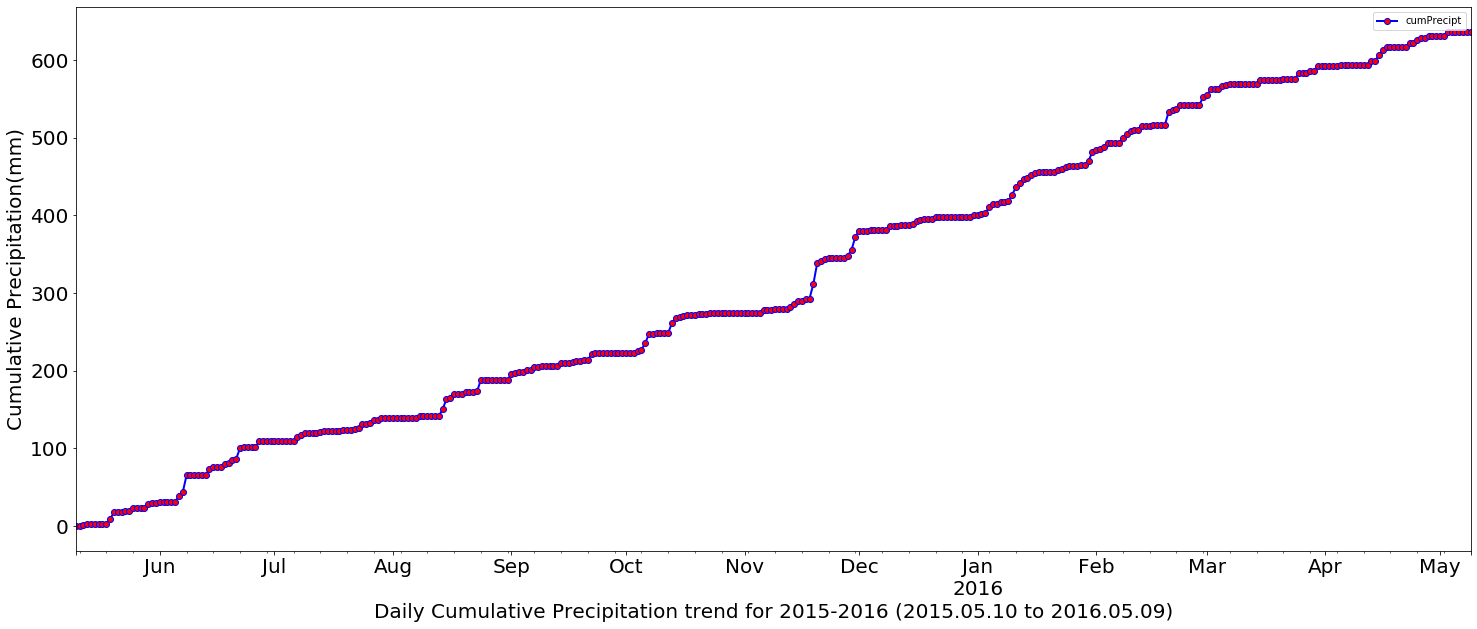

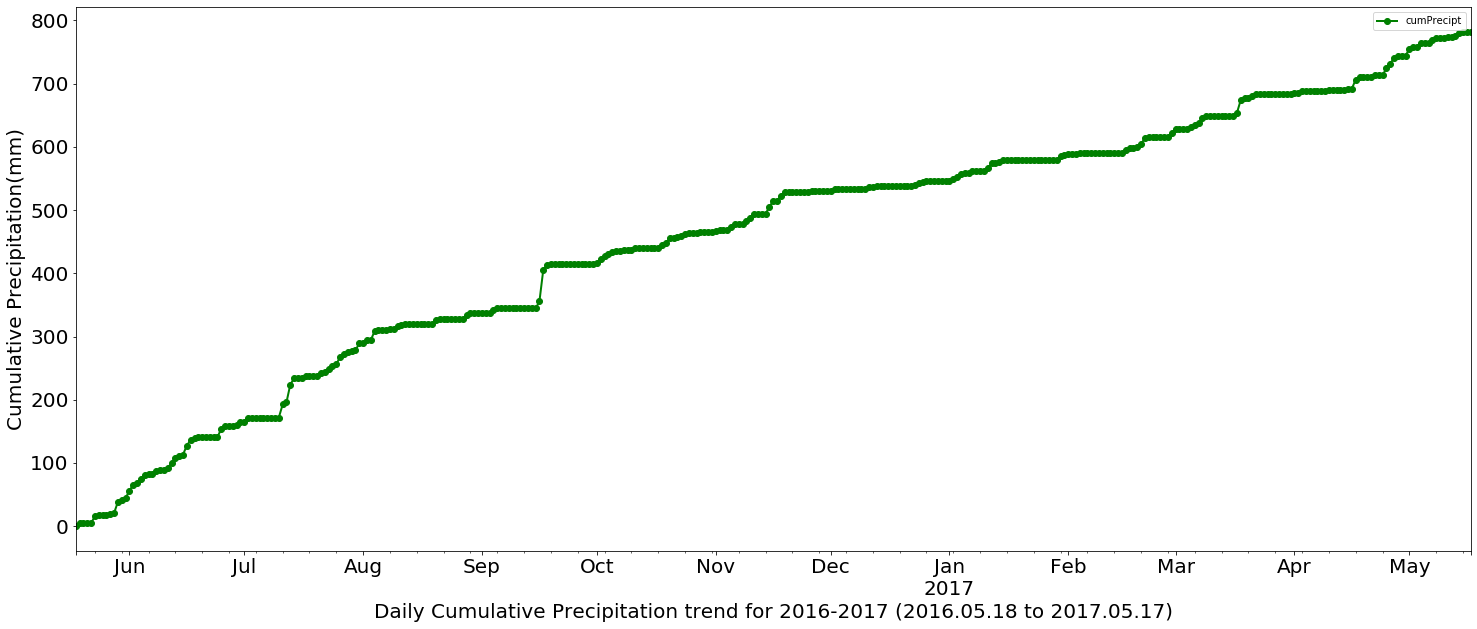

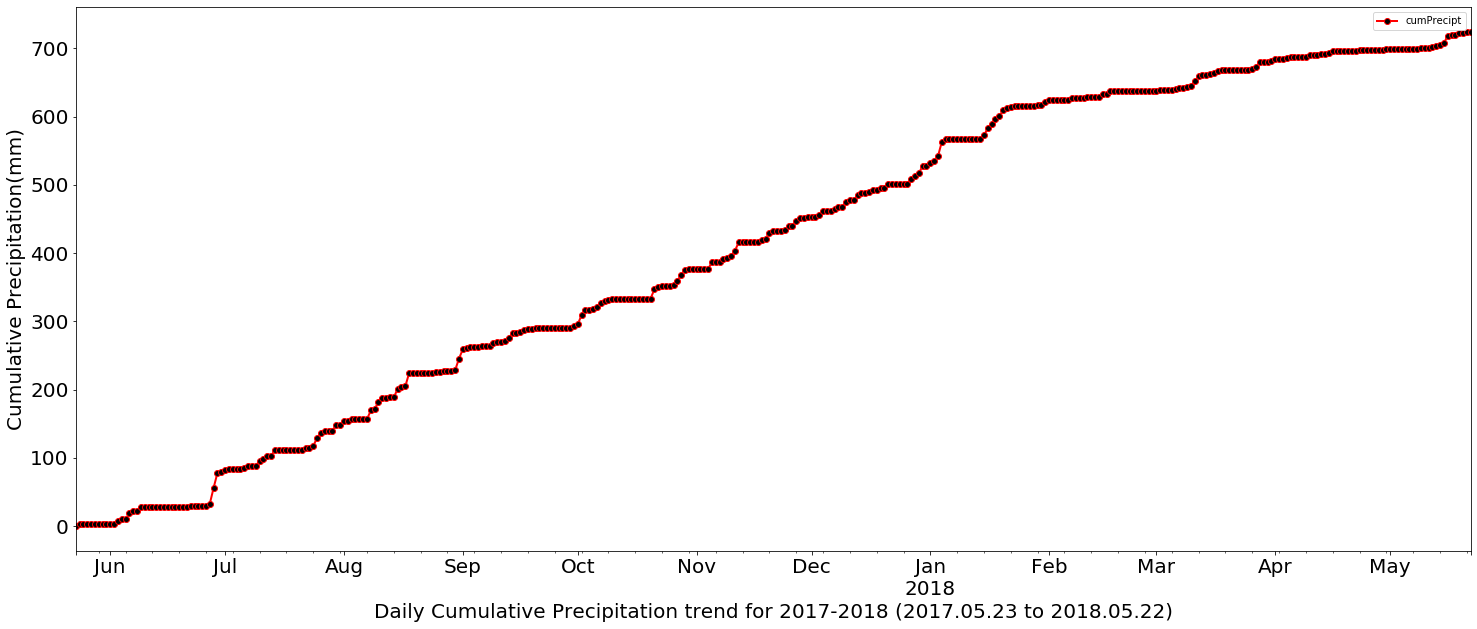

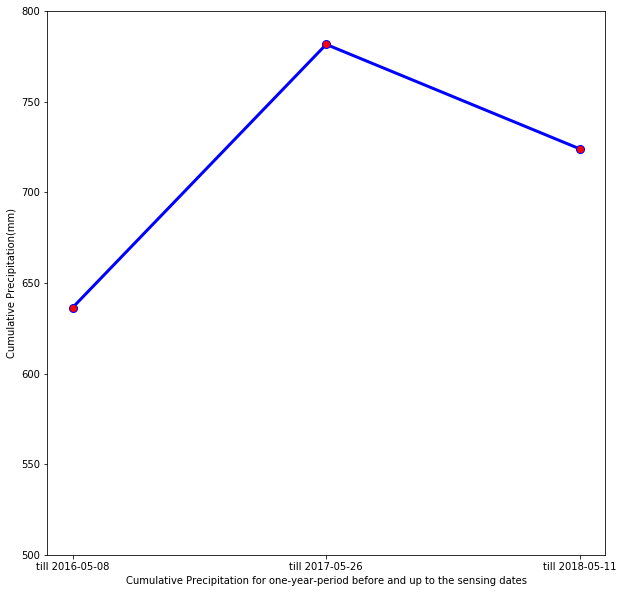

In [248]:
#The days selected are (a) 2016-05-09 (c) 2017-05-17 (e) 2018-05-22
# line plot for avg tempertaure vs time form 2015-05-10 to 2016-05-09
df_date_precip2016.plot(kind='line',x='time',y='cumPrecipt',color='blue', linewidth = 2,figsize=(25, 10), marker='o', markerfacecolor='red',)
plt.xlabel('Daily Cumulative Precipitation trend for 2015-2016 (2015.05.10 to 2016.05.09)', fontsize=20)
plt.ylabel('Cumulative Precipitation(mm)', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.tick_params(axis='both', which='minor', labelsize=20)
plt.savefig("precipitation2016.png")
# line plot for avg tempertaure vs time form 2016-05-18 to 2017-05-17
df_date_precip2017.plot(kind='line',x='time',y='cumPrecipt',color='green', linewidth = 2,figsize=(25, 10), marker='o', markerfacecolor='green',)
plt.xlabel('Daily Cumulative Precipitation trend for 2016-2017 (2016.05.18 to 2017.05.17)', fontsize=20)
plt.ylabel('Cumulative Precipitation(mm)', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.tick_params(axis='both', which='minor', labelsize=20)
plt.savefig("precipitation2017.png")
# line plot for avg tempertaure vs time form 2017-05-23 to 2018-05-22
df_date_precip2018.plot(kind='line',x='time',y='cumPrecipt',color='red', linewidth = 2,figsize=(25, 10), marker='o', markerfacecolor='black',)
plt.xlabel('Daily Cumulative Precipitation trend for 2017-2018 (2017.05.23 to 2018.05.22)', fontsize=20)
plt.ylabel('Cumulative Precipitation(mm)', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.tick_params(axis='both', which='minor', labelsize=20)
plt.savefig("precipitation2018.png")
#Displaying cumulative precpitation values for month of May and June in the year 2016, 2017, 2018 for 3 dataframe
sensing_date = ['till 2016-05-08', 'till 2017-05-26', 'till 2018-05-11']
cumPrecipt = [df_date_precip2016['cumPrecipt'].iloc[-1], df_date_precip2017['cumPrecipt'].iloc[-1], df_date_precip2018['cumPrecipt'].iloc[-1]]
print('The cumulative precpitation are:')
print(cumPrecipt)
#Line graph
plt.figure(figsize=(10,10))
plt.plot(sensing_date, cumPrecipt, color='blue', linewidth = 3, marker='o', markerfacecolor='red', markersize=8)
axes = plt.gca()
axes.set_ylim([500,800])
plt.xlabel('Cumulative Precipitation for one-year-period before and up to the sensing dates')
plt.ylabel('Cumulative Precipitation(mm)')
plt.savefig("linegraph_precipt.png")
plt.show()

## save data

In [249]:
df_all_date = df_date_precip2016.append(df_date_precip2017)
df_all_date = df_all_date.append(df_date_precip2018)
df_all_date.to_csv('cumulated_precipitation.csv',index = True)
df_all_date.shape

(1096, 51)

In [250]:
df_all_date.drop_duplicates(keep='first',inplace=True)
df_all_date.shape

(1096, 51)

In [251]:
df_all_date.head()

time  46  103  118  128  572  589  851  1391  1392  ...  5485  \
49711 2015-05-10 NaN  0.0  0.0  0.0  0.0  0.0  0.0   0.0   0.0  ...   0.0   
49712 2015-05-11 NaN  0.0  0.0  0.0  0.0  0.0  0.0   0.0   0.0  ...   0.0   
49713 2015-05-12 NaN  0.0  5.5  0.0  1.9  0.0  9.5   6.6   6.7  ...   2.1   
49714 2015-05-13 NaN  1.0  0.2  0.0  0.0  0.9  0.0   0.0   0.1  ...   0.0   
49715 2015-05-14 NaN  0.0  0.2  0.0  0.0  0.0  0.0   0.0   0.3  ...   0.0   

       5548  5658  5753  5959  6216  7350  7370   precipt  cumPrecipt  
49711   0.0   0.1   0.0   0.0   0.0   0.0   0.0  0.011905    0.011905  
49712   0.0   0.0   0.0   0.0   0.0   0.0   0.0  0.000000    0.011905  
49713   0.0   0.0   0.0   0.0   2.2   0.0   4.7  1.800000    1.811905  
49714   0.0   0.2   0.0   0.4   0.0   0.2   0.1  0.495238    2.307143  
49715   0.0   0.0   0.0   0.0   0.1   0.1   0.0  0.021429    2.328571  

[5 rows x 51 columns]

In [252]:
station_ids = df_all_date.columns.drop(['time','precipt']).tolist()

In [253]:
df_all_precpit = df_all_date[['time','cumPrecipt']]
df_all_precpit.drop_duplicates(keep='first',inplace=True)
df_all_precpit.shape
df_all_precpit.to_csv('cumulated_precipitation.csv',index = True)


C:\Users\acer\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [254]:
df_date_precip2016['precipt'].sum()

636.4035991140643

In [255]:
df_date_precip2017['precipt'].sum()

781.6790697674419

In [256]:
df_date_precip2018['precipt'].sum()

724.0139534883722

In [257]:
df_stations.to_csv('timeseries_preciptation.csv',index= True)
